___
___
___
# Light GBM
___
___
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# df = pd.read_csv('./data_set/SBAnational-EDA.csv')
df = pd.read_csv('./data_set/SBAnational1000.csv')
df = df.drop(columns=['Unnamed: 0'], axis=1).reset_index(drop=True)

df.columns

/home/utilisateur/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Index(['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'ApprovalDate',
       'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'MIS_Status',
       'GrAppv', 'SBA_Appv', 'NAICS2', 'DiffJobs'],
      dtype='object')

In [ ]:
dd = df.groupby(['ApprovalFY', 'MIS_Status']).size().reset_index(name='count')

# Pivoter les résultats
dd = dd.pivot(index='ApprovalFY', columns='MIS_Status', values='count').reset_index()

# Remplacer les NaN par 0
dd.fillna(0, inplace=True)

# Créer une nouvelle colonne basée sur la comparaison 'CHGOFF' > 'P I F'
dd['ApprovalFY_bool'] = dd.apply(lambda row: 0 if row['CHGOFF'] > row['P I F'] else 1, axis=1)

dd = dd[['ApprovalFY_bool']]

df = pd.concat([df, dd], axis=1)

In [ ]:
df = df[[
    'City',
    'State',
    'Zip',
    'Bank',
    'BankState',
    'NAICS',
    # 'NAICS2',
    'ApprovalDate',
    'ApprovalFY',
    # 'ApprovalFY_bool',
    'Term',
    'NoEmp',
    'NewExist',
    'CreateJob',
    'RetainedJob',
    'DiffJobs',
    'FranchiseCode',
    'UrbanRural',
    'RevLineCr',
    'LowDoc',
    'GrAppv',
    'SBA_Appv',
    'MIS_Status',
    ]]

In [ ]:
df.head(1).transpose()

,0
City,EVANSVILLE
State,IN
Zip,47711
Bank,FIFTH THIRD BANK
BankState,IN
NAICS,451120
ApprovalDate,1997-02-28
ApprovalFY,1997-01-01
Term,84
NoEmp,4


In [ ]:
colonnes_numeriques = df.select_dtypes(include=['number']).columns.tolist()

# Sélectionner les colonnes non numériques
colonnes_non_numeriques = df.drop(columns=colonnes_numeriques).columns.tolist()

print(colonnes_numeriques)
print(colonnes_non_numeriques)

['Zip', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'DiffJobs', 'FranchiseCode', 'UrbanRural', 'GrAppv', 'SBA_Appv']
['City', 'State', 'Bank', 'BankState', 'ApprovalDate', 'ApprovalFY', 'RevLineCr', 'LowDoc', 'MIS_Status']


In [ ]:
# Créer un nouveau DataFrame sans les lignes contenant des valeurs NaN
# df = df.dropna()

# Vérifier s'il y a des valeurs manquantes dans le DataFrame
missing_values = df.isnull().sum()
# Afficher les colonnes avec des valeurs manquantes
print("Colonnes avec des valeurs manquantes :\n", missing_values[missing_values > 0])

# Vérifier les types de données de chaque colonne
# data_types = df.dtypes
# Afficher les types de données de chaque colonne
# print("Types de données de chaque colonne :\n", data_types)

Colonnes avec des valeurs manquantes :
 Series([], dtype: int64)


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from datetime import datetime

grid_search_bool = False

numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

# Définir le preprocessor
label_encoder = LabelEncoder()
preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), numerical_features),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='if_binary')), categorical_features),
)

# Prétraiter les données
X = preprocessor.fit_transform(df.drop(columns='MIS_Status'))
y = label_encoder.fit_transform(df['MIS_Status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.05, random_state=42, stratify=y)
# y_train = y_train.astype(int).tolist()
# y_test = y_test.astype(int).tolist()

if grid_search_bool == False:
    # LGBM
    d_train = lgb.Dataset(X_train, label=y_train)

    # https://lightgbm.readthedocs.io/en/latest/Parameters.html
    # best f1 macro : 0.9154
    # 
    lgbm_params = {
        'objective': ['multiclass'], # binary multiclass
        'num_class': 2,
        'boosting_type': ['gbdt'], # dart goss rf
        'metric': ['multi_logloss'],
        'num_leaves': [500], # [10, 50, 100]
        'learning_rate': [0.2], # [0.01, 0.05, 0.1, 0.2]
        'feature_fraction': [0.8],
        'bagging_fraction': [0.8],
        'bagging_freq': [5],
        'lambda_l1': [1], # [0.1, 0.5, 1.0, 2.0]
        'lambda_l2': [1], # [0.1, 0.5, 1.0, 2.0]
        'verbose': [1],
    }
    # pycaret
    # lgbm_params = {
    #     'objective': [None],
    #     'class_weight': [None],
    #     'colsample_bytree': [1.0],
    #     'importance_type': ['split'],
    #     'learning_rate': [0.1],
    #     'max_depth': [-1],
    #     'min_child_samples': [20],
    #     'min_child_weight': [0.001],
    #     'min_split_gain': [0.0],
    #     'n_estimators': [100],
    #     'n_jobs': [-1],
    #     'num_leaves': [31],
    #     'random_state': [0],
    #     'reg_alpha': [0.0],
    #     'reg_lambda': [0.0],
    #     'subsample': [1.0],
    #     'subsample_for_bin': [200000],
    #     'subsample_freq': [0],
    #     'metric': ['f1'],
    #     # 'feature_fraction': [0.8],
    #     # 'bagging_fraction': [0.8],
    #     # 'bagging_freq': [10],
    #     # 'lambda_l1': [1], # [0.1, 0.5, 1.0, 2.0]
    #     # 'lambda_l2': [1], # [0.1, 0.5, 1.0, 2.0]
    #     # 'verbose': [1],
    # }

    start=datetime.now()
    clf = lgb.train(lgbm_params, d_train, 50) #50 iterations. Increase iterations for small learning rates
    stop=datetime.now()
    execution_time_lgbm = stop-start

    #Prediction on test data
    y_pred_lgbm=clf.predict(X_test)

    #convert into binary values 0/1 for classification
    y_pred_lgbm = [list(x).index(max(x)) for x in y_pred_lgbm]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 976, number of used features: 59
[LightGBM] [Info] Start training from score -1.948989
[LightGBM] [Info] Start training from score -0.153639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

#########################################################
     LGBM execution time is:  0:00:00.190678
#########################################################
              precision    recall  f1-score    support
0              0.800000  0.571429  0.666667   7.000000
1              0.936170  0.977778  0.956522  45.000000
accuracy       0.923077  0.923077  0.923077   0.923077
macro avg      0.868085  0.774603  0.811594  52.000000
weighted avg   0.917840  0.923077  0.917503  52.000000
#########################################################
                  F1 macro score: 0.8116
#########################################################


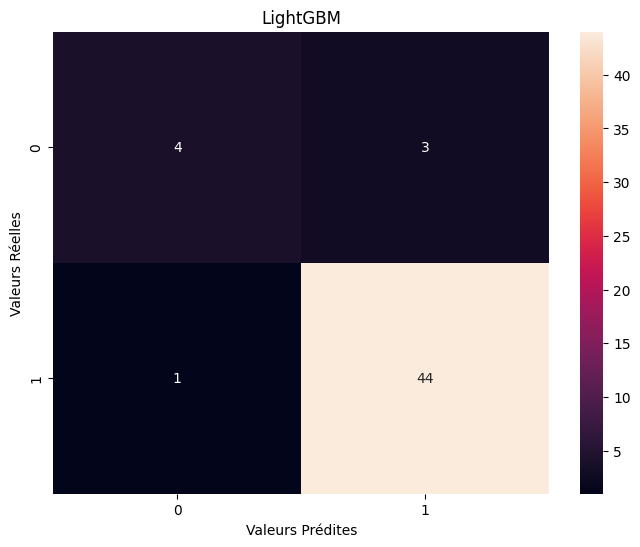

In [ ]:
if grid_search_bool == False:
    plt.figure(figsize=(8, 6))
    cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
    sns.heatmap(cm_lgbm, annot=True)
    plt.title("LightGBM")
    plt.xlabel('Valeurs Prédites')
    plt.ylabel('Valeurs Réelles')

    ################
    #SUMMARY
    report = classification_report(y_test, y_pred_lgbm, output_dict=True)
    df_report = pd.DataFrame(report)
    print("#########################################################")
    print("     LGBM execution time is: ", execution_time_lgbm)
    print("#########################################################")
    print(df_report.T)
    print("#########################################################")
    print("                  F1 macro score:", round(report["macro avg"]["f1-score"], 4))
    print("#########################################################")

___
___
___
### nouvelle version : XGBoost
___
___
___

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import xgboost as xgb


label_encoder = LabelEncoder()
preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), numerical_features),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), categorical_features),
)

# Définition du pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='error',
        eta=0.1,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        seed=42
    ))
])

# Séparation des fonctionnalités et de la variable cible
X = df.drop(columns='MIS_Status')
y = label_encoder.fit_transform(df['MIS_Status'])

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du pipeline
start=datetime.now()
pipeline.fit(X_train, y_train)
stop=datetime.now()
execution_time = stop-start

# Évaluation du pipeline
y_pred = pipeline.predict(X_test)
print("execution_time:", execution_time)


execution_time: 0:00:00.178336


#########################################################
      XGBoost execution time is:  0:00:00.178336
#########################################################
              precision    recall  f1-score     support
0              0.761905  0.533333  0.627451   30.000000
1              0.924324  0.971591  0.947368  176.000000
accuracy       0.907767  0.907767  0.907767    0.907767
macro avg      0.843115  0.752462  0.787410  206.000000
weighted avg   0.900671  0.907767  0.900779  206.000000
#########################################################
                  F1 macro score: 0.7874
#########################################################


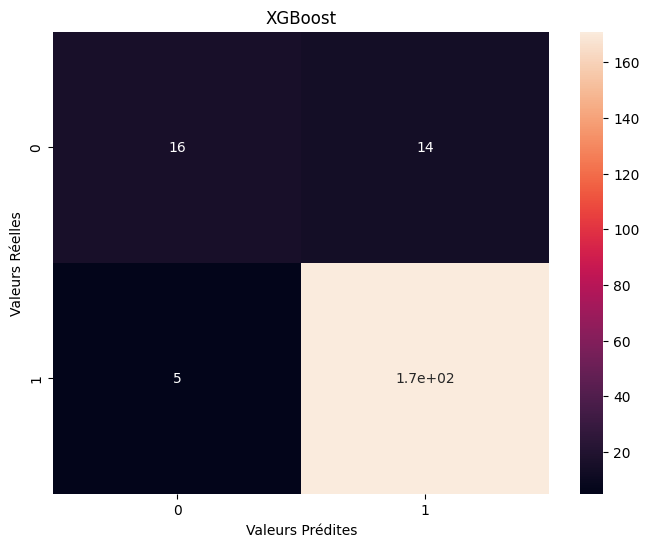

In [ ]:
#Prediction on test data
y_pred_XGB=pipeline.predict(X_test)

if grid_search_bool == False:
    plt.figure(figsize=(8, 6))
    cm_XGB = confusion_matrix(y_test, y_pred_XGB)
    sns.heatmap(cm_XGB, annot=True)
    plt.title("XGBoost")
    plt.xlabel('Valeurs Prédites')
    plt.ylabel('Valeurs Réelles')

    ################
    #SUMMARY
    report = classification_report(y_test, y_pred_XGB, output_dict=True)
    df_report = pd.DataFrame(report)
    print("#########################################################")
    print("      XGBoost execution time is: ", execution_time)
    print("#########################################################")
    print(df_report.T)
    print("#########################################################")
    print("                  F1 macro score:", round(report["macro avg"]["f1-score"], 4))
    print("#########################################################")

___
# PICKLE

In [ ]:
import pickle

# Définir le nom du fichier pkl
filename = './model/modelXGB.pkl'

# Sauvegarder le modèle dans le fichier pkl
with open(filename, 'wb') as file:
    pickle.dump(pipeline, file)


FileNotFoundError: [Errno 2] No such file or directory: './model/modelXGB.pkl'